In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from tqdm.auto import tqdm, trange

from src.analysis.state_space import StateSpaceAnalysisSpec
from src.datasets.speech_equivalence import SpeechHiddenStateDataset

In [34]:
dataset_path = "outputs/preprocessed_data/timit"
hidden_states_path = "outputs/hidden_states/timit/w2v2_6/hidden_states.pkl"
state_space_specs_path = "outputs/state_space_specs/timit/w2v2_6/state_space_specs.pkl"

model_embedding_paths = {
    "phoneme8": "outputs/model_embeddings/timit/w2v2_6/rnn_8/phoneme/embeddings.npy",
    "next_phoneme": "outputs/model_embeddings/timit/w2v2_6/rnn_8/next_phoneme/embeddings.npy",

    "biphone_pred": "outputs/model_embeddings/timit/w2v2_6/rnn_8/biphone_pred/embeddings.npy",
    "biphone_recon": "outputs/model_embeddings/timit/w2v2_6/rnn_8/biphone_recon/embeddings.npy",

    "syllable": "outputs/model_embeddings/timit/w2v2_6/rnn_8/syllable/embeddings.npy",

    "word": "outputs/model_embeddings/timit/w2v2_6/rnn_8/word/embeddings.npy",
}

# If not None, spatially smooth the synthetic encoding target with the given window size.
target_smoosh = None

# Number of principal components to retain in the synthetic encoding target. If `None`,
# do not perform dimensionality reduction.
num_components = 10

# Number of model embeddings to select in forward selection
num_embeddings_to_select = 3

# Remove the top K principal components from model embeddings.
# This can be appropriate for anisotropic embeddings
embedding_remove_components = None

# Subsample hidden states following dataset annotations
subsample_strategy = "all"

output_dir = "."

In [35]:
assert len(model_embedding_paths) >= num_embeddings_to_select

assert subsample_strategy in {"all", "multisyllabic", "monosyllabic"}

In [6]:
with open(hidden_states_path, "rb") as f:
    hidden_states: SpeechHiddenStateDataset = torch.load(f)

In [29]:
with open(state_space_specs_path, "rb") as f:
    state_space_specs: dict[str, StateSpaceAnalysisSpec] = torch.load(f)

In [12]:
model_embeddings = {
    model_name: np.load(path)
    for model_name, path in model_embedding_paths.items()
}

In [13]:
for model_name, embeddings in model_embeddings.items():
    assert embeddings.shape[0] == hidden_states.num_frames, f"{model_name} {embeddings.shape[0]} {hidden_states.num_frames}"

In [14]:
if embedding_remove_components is not None:
    for model_name, embeddings in model_embeddings.items():
        pca = PCA(n_components=embedding_remove_components).fit(embeddings)

        # Remove the top K components
        embeddings -= embeddings @ pca.components_.T @ pca.components_
        model_embeddings[model_name] = embeddings

## Model forward selection

In [10]:
def block_mean(ar, fact):
    assert isinstance(fact, int), type(fact)
    sx, sy = ar.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    regions = sy//fact * (X//fact) + Y//fact
    res = ndimage.mean(ar, labels=regions, index=np.arange(regions.max() + 1))
    res.shape = (sx//fact, sy//fact)
    return res


def get_design_matrix_mask(selection, select_embedding_mask):
    total_num_features = sum(embeddings.shape[1] for embeddings in model_embeddings.values())
    mask = np.zeros(total_num_features, dtype=bool)
    for model_name in selection:
        mask |= select_embedding_mask[model_name]
    return mask


def estimate_model_with_selection(model, X_train, Y_train, X_test, Y_test, selection, select_embedding_mask):
    mask = get_design_matrix_mask(selection, select_embedding_mask)
    model = model.fit(X_train[:, mask], Y_train)

    train_score = model.score(X_train[:, mask], Y_train)
    test_score = model.score(X_test[:, mask], Y_test)
    return model, train_score, test_score


def do_forward_selection(select_embeddings, sample_idxs=None,
                         target_smoosh=None, num_components=None):
    X = np.concatenate([model_embeddings[model_name] for model_name in select_embeddings], axis=1)
    Y = hidden_states.states[:, 0, :].numpy()

    if sample_idxs is None:
        sample_idxs = np.random.choice(X.shape[0], 100000, replace=False)
    X = X[sample_idxs]
    Y = Y[sample_idxs]

    if target_smoosh is not None:
        Y = np.array([
            block_mean(hs.reshape((32, 24)), target_smoosh).ravel()
            for hs in tqdm(Y)
        ])

    X = StandardScaler(with_std=False).fit_transform(X)
    Y = StandardScaler().fit_transform(Y)

    if num_components is not None:
        pca = PCA(n_components=num_components)
        Y = pca.fit_transform(Y)

        # plot cumulative explained variance
        f, ax = plt.subplots(figsize=(10, 5))
        ax.plot(np.cumsum(pca.explained_variance_ratio_))
        ax.set_xlabel("number of components")
        ax.set_ylabel("cumulative explained variance")

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True)

    # Prepare design matrix masks
    select_embedding_mask = {}
    cum_idx = 0
    
    total_num_features = sum(embeddings.shape[1] for embeddings in model_embeddings.values())
    design_matrix = np.zeros((hidden_states.num_frames, total_num_features))
    for i, model_name in enumerate(select_embeddings):
        model_dim = model_embeddings[model_name].shape[1]
        select_embedding_mask[model_name] = np.zeros(total_num_features, dtype=bool)
        select_embedding_mask[model_name][cum_idx : cum_idx + model_dim] = True

        design_matrix[:, cum_idx : cum_idx + model_dim] = model_embeddings[model_name]

        cum_idx += model_dim

    spec_trajectory = [[]]
    model_trajectory = [None]
    score_trajectory = [-np.inf]
    assert num_embeddings_to_select <= len(select_embeddings)

    # base_model = Ridge(solver="saga", max_iter=10000, random_state=0)
    base_model = RidgeCV(alphas=np.logspace(-3, 3, 10),
                        cv=KFold(n_splits=5, shuffle=True, random_state=0))

    for _ in trange(num_embeddings_to_select):
        candidate_embeddings = list(set(select_embeddings) - set(spec_trajectory[-1]))
        candidate_models = []
        candidate_scores = []

        for embedding_name in candidate_embeddings:
            candidate_model, _, candidate_score = estimate_model_with_selection(
                clone(base_model), X_train, Y_train, X_test, Y_test,
                spec_trajectory[-1] + [embedding_name],
                select_embedding_mask)

            candidate_models.append(candidate_model)
            candidate_scores.append(candidate_score)
            print(f"{spec_trajectory[-1] + [embedding_name]}: {candidate_score}")

        best_candidate_score = np.max(candidate_scores)
        best_candidate_idx = np.argmax(candidate_scores)
        best_candidate_model = candidate_models[best_candidate_idx]

        if best_candidate_score > score_trajectory[-1]:
            spec_trajectory.append(spec_trajectory[-1] + [candidate_embeddings[best_candidate_idx]])
            model_trajectory.append(best_candidate_model)
            score_trajectory.append(best_candidate_score)
        else:
            print("No improvement")
            break

    return spec_trajectory, model_trajectory, score_trajectory
            

In [36]:
if subsample_strategy == "all":
    sample_idxs = None
else:
    if subsample_strategy == "multisyllabic":
        multisyllable_cuts = state_space_specs["word"].cuts.groupby(["label", "instance_idx"]) \
            .filter(lambda xs: len(xs.xs("syllable", level="level")) > 1)
        subsample_trajs = {(label, instance_idx) for label, instance_idx, _ in multisyllable_cuts.index}
    elif subsample_strategy == "monosyllabic":
        monosyllable_cuts = state_space_specs["word"].cuts.groupby(["label", "instance_idx"]) \
            .filter(lambda xs: len(xs.xs("syllable", level="level")) == 1)
        subsample_trajs = {(label, instance_idx) for label, instance_idx, _ in monosyllable_cuts.index}
    else:
        raise ValueError(subsample_strategy)
    
    sample_idxs = []
    for traj_label, traj_instance_idx in subsample_trajs:
        label_idx = state_space_specs["word"].labels.index(traj_label)
        start, end = state_space_specs["word"].target_frame_spans[label_idx][traj_instance_idx]
        sample_idxs.append(np.arange(start, end + 1))

    sample_idxs = np.concatenate(sample_idxs)

In [39]:
if sample_idxs is not None:
    print(len(sample_idxs), len(sample_idxs) / hidden_states.num_frames)

  0%|          | 0/3 [00:00<?, ?it/s]

['phoneme8']: 0.09728408886056641
['syllable']: 0.12152074101601303
['next_phoneme']: 0.08614678023676471
['biphone_pred']: 0.11341650513957333
['biphone_recon']: 0.15973305961091197
['word']: 0.06031197462545551
['biphone_recon', 'biphone_pred']: 0.2232892333425438
['biphone_recon', 'phoneme8']: 0.2091562406691211
['biphone_recon', 'syllable']: 0.23352178567590132
['biphone_recon', 'next_phoneme']: 0.21928891431746617
['biphone_recon', 'word']: 0.2033826846262526
['biphone_recon', 'syllable', 'phoneme8']: 0.26803834394981135
['biphone_recon', 'syllable', 'word']: 0.26729175449708453
['biphone_recon', 'syllable', 'next_phoneme']: 0.28728265946657905
['biphone_recon', 'syllable', 'biphone_pred']: 0.27776569557413466


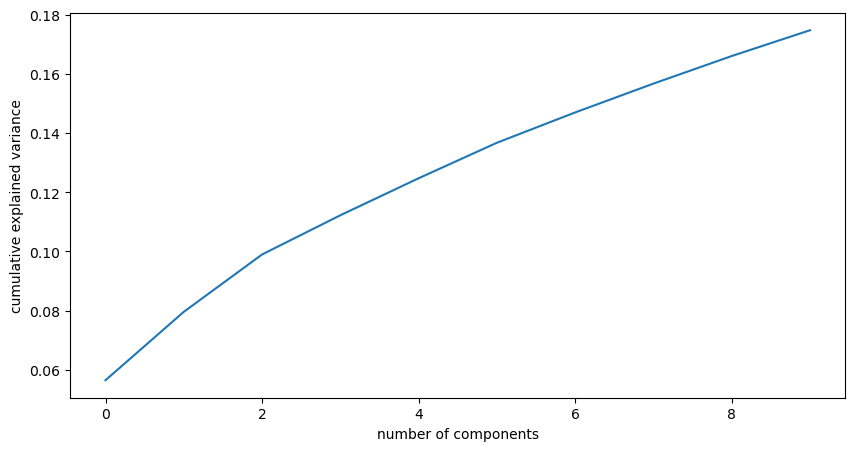

In [32]:
select_embeddings = list(model_embeddings.keys())
spec_trajectory, model_trajectory, score_trajectory = do_forward_selection(
    select_embeddings, target_smoosh=target_smoosh, num_components=num_components,
    sample_idxs=sample_idxs)

In [ ]:
with open(f"{output_dir}/forward_selection.pkl", "wb") as f:
    pickle.dump({
        "spec_trajectory": spec_trajectory,
        "model_trajectory": model_trajectory,
        "score_trajectory": score_trajectory
    }, f)